In [1]:
import pandas as pd
import regex as re
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, lr_scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SEP_TOKEN = '▁<extra_id_0>'    #' ; '

In [3]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    # Фильтрация
    text = re.sub ('``', '\"', text)
    text = re.sub ('\'\'', '\"', text)
    text = re.sub ('[“”]', '\"', text)

    # Создаем регулярное выражение для разделителей
    delimiters_pattern = '|'.join(map(re.escape, delimiters))
    
    # Разделяем текст на абзацы
    paragraphs = text.split ('\n')
    
    # Список для хранения предложений и их индексов
    sentences_with_segments = []
    
    current_start_index = 0
    # Обрабатываем каждый абзац
    for paragraph in paragraphs:
        # Разделяем абзац на предложения
        sentences = re.split (f'(?<=[{delimiters_pattern}]) (?=[A-ZА-ЯЁ])', paragraph.strip ())

        #print ('\nРассматривается параграф: ', paragraph)
        
        # Сопоставляем предложения с сегментами
        for sentence in sentences:
            #print ('> Предложение:', sentence)
            # Ищем индексы символов для текущего предложения
            start_index = current_start_index
            end_index = start_index + len (sentence)
            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index += len (sentence)

            #print ('Термины:', matched_segments)
    
    return sentences_with_segments

parallel_text = []
parallel_label = []
#for i, row in tqdm (df.iterrows (), total = df.shape [0], desc = "Processing texts: "):
for i, row in df.iterrows ():
    text = row ['text']
    segments = row ['label']
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text.append (sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label.append ('')

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  


In [4]:
USED_MODEL_NAME = 'cointegrated/rut5-small'
#USED_MODEL_NAME = './coint_rut5small_finetune_5875'
#USED_MODEL_NAME = 'ai-forever/ruT5-base'
SEQ_MAX_LENGTH = 150
BATCH_SIZE = 8
EVAL_BATCH_SIZE = 8

In [5]:
#tokenizer = T5Tokenizer.from_pretrained (USED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)
tokenizer

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


T5TokenizerFast(name_or_path='cointegrated/rut5-small', vocab_size=20200, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', 

In [6]:
#tokenizer.add_special_tokens ({'additional_special_tokens': str (SEP_TOKEN)})
#tokenizer

In [7]:
enc = tokenizer (parallel_label [3], padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
enc


{'input_ids': tensor([[ 5269,  1531,  8484,  9304,   433, 20099,  6972, 17003,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [8]:
tokenizer.batch_decode (enc ['input_ids'])

['Речевые формулы <extra_id_0> диалоге</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [9]:
train_data_txt, temp_data_txt, train_labels_txt, temp_labels_txt = train_test_split (parallel_text, parallel_label, test_size = 0.2, random_state = 14)
val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (temp_data_txt, temp_labels_txt, test_size = 0.5, random_state = 14)

In [10]:
train_data = tokenizer (train_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (train_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

val_data = tokenizer (val_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

In [11]:
class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

train_dataset = Seq2SeqDataset (train_data, train_labels)
val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [12]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)
#model.train ()


cuda:0


In [13]:
def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [14]:
metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

In [ ]:
for param in model.parameters ():
    param.requires_grad = True

In [18]:
num_epochs = 50
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

Suggested train steps: 20900
	 warmup steps: 1045 - 2090


In [ ]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)
#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = 2000, num_training_steps = 21000)

In [ ]:
num_epochs = 50
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0
    
    for batch in tqdm (train_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

        #scheduler.step ()  # Обновление learning rate
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

100%|██████████| 419/419 [00:41<00:00, 10.10it/s]


Epoch 1 / 50, Loss: 21.0087, Validation loss: 20.1674, 0.0 / 0.0 / 0


100%|██████████| 419/419 [00:40<00:00, 10.33it/s]


Epoch 2 / 50, Loss: 18.1358, Validation loss: 13.9995, 0.0 / 0.0 / 0


100%|██████████| 419/419 [00:40<00:00, 10.22it/s]


Epoch 3 / 50, Loss: 13.7335, Validation loss: 10.8358, 0.0 / 0.0 / 0


100%|██████████| 419/419 [00:41<00:00, 10.00it/s]


Epoch 4 / 50, Loss: 10.8694, Validation loss: 8.6822, 0.0 / 0.0 / 0


100%|██████████| 419/419 [00:42<00:00,  9.92it/s]


Epoch 5 / 50, Loss: 7.4668, Validation loss: 4.4505, 0.007058823529411765 / 0.001763668430335097 / 0.002822201317027281


100%|██████████| 419/419 [00:41<00:00, 10.20it/s]


Epoch 6 / 50, Loss: 4.1742, Validation loss: 2.5124, 0.04784688995215311 / 0.011757789535567314 / 0.018876828692779613


100%|██████████| 419/419 [00:42<00:00,  9.95it/s]


Epoch 7 / 50, Loss: 1.9026, Validation loss: 0.5142, 0.05741626794258373 / 0.014109347442680775 / 0.022652194431335537


100%|██████████| 419/419 [00:45<00:00,  9.25it/s]


Epoch 8 / 50, Loss: 0.8904, Validation loss: 0.3673, 0.05741626794258373 / 0.014109347442680775 / 0.022652194431335537


100%|██████████| 419/419 [00:45<00:00,  9.28it/s]


Epoch 9 / 50, Loss: 0.6154, Validation loss: 0.2953, 0.05787037037037037 / 0.014697236919459141 / 0.02344116268166901


100%|██████████| 419/419 [00:45<00:00,  9.30it/s]


Epoch 10 / 50, Loss: 0.4664, Validation loss: 0.2423, 0.13028169014084506 / 0.04350382128159906 / 0.06522697223446453


100%|██████████| 419/419 [00:40<00:00, 10.37it/s]


Epoch 11 / 50, Loss: 0.3739, Validation loss: 0.2104, 0.1951501154734411 / 0.0993533215755438 / 0.13167121153097003


100%|██████████| 419/419 [00:52<00:00,  7.93it/s]


Epoch 12 / 50, Loss: 0.3207, Validation loss: 0.1881, 0.23414634146341465 / 0.14109347442680775 / 0.1760821716801174


100%|██████████| 419/419 [00:48<00:00,  8.57it/s]


Epoch 13 / 50, Loss: 0.2754, Validation loss: 0.1724, 0.26394052044609667 / 0.16696061140505586 / 0.204537270435722


100%|██████████| 419/419 [00:48<00:00,  8.70it/s]


Epoch 14 / 50, Loss: 0.2508, Validation loss: 0.1596, 0.2888086642599278 / 0.18812463256907702 / 0.22783908864364544


100%|██████████| 419/419 [00:48<00:00,  8.59it/s]


Epoch 15 / 50, Loss: 0.2296, Validation loss: 0.1503, 0.30572687224669604 / 0.2039976484420929 / 0.2447108603667137


100%|██████████| 419/419 [00:49<00:00,  8.50it/s]


Epoch 16 / 50, Loss: 0.2133, Validation loss: 0.1411, 0.337617823479006 / 0.23162845385067607 / 0.27475592747559274


100%|██████████| 419/419 [00:48<00:00,  8.72it/s]


Epoch 17 / 50, Loss: 0.1977, Validation loss: 0.1337, 0.35598980458793544 / 0.24632569077013522 / 0.291174426685198


100%|██████████| 419/419 [00:47<00:00,  8.75it/s]


Epoch 18 / 50, Loss: 0.1912, Validation loss: 0.1278, 0.37193575655114114 / 0.2586713697824809 / 0.30513176144244103


100%|██████████| 419/419 [00:47<00:00,  8.77it/s]


Epoch 19 / 50, Loss: 0.1793, Validation loss: 0.1230, 0.39243697478991596 / 0.27454438565549677 / 0.32307160152196474


100%|██████████| 419/419 [00:48<00:00,  8.73it/s]


Epoch 20 / 50, Loss: 0.1697, Validation loss: 0.1176, 0.409688013136289 / 0.2933568489124045 / 0.34189791024323396


100%|██████████| 419/419 [00:47<00:00,  8.85it/s]


Epoch 21 / 50, Loss: 0.1641, Validation loss: 0.1128, 0.4110479285134037 / 0.29747207524985303 / 0.3451568894952251


100%|██████████| 419/419 [00:47<00:00,  8.84it/s]


Epoch 22 / 50, Loss: 0.1571, Validation loss: 0.1093, 0.4206219312602291 / 0.30217519106408 / 0.35169346561751624


100%|██████████| 419/419 [00:47<00:00,  8.81it/s]


Epoch 23 / 50, Loss: 0.1502, Validation loss: 0.1054, 0.436 / 0.3203997648442093 / 0.3693663165028804


100%|██████████| 419/419 [00:47<00:00,  8.82it/s]


Epoch 24 / 50, Loss: 0.1460, Validation loss: 0.1019, 0.4392 / 0.32275132275132273 / 0.3720772619451033


100%|██████████| 419/419 [00:47<00:00,  8.79it/s]


Epoch 25 / 50, Loss: 0.1395, Validation loss: 0.0996, 0.4510268562401264 / 0.3356848912404468 / 0.3849005729693294


100%|██████████| 419/419 [00:47<00:00,  8.82it/s]


Epoch 26 / 50, Loss: 0.1356, Validation loss: 0.0963, 0.45591739475774423 / 0.3374485596707819 / 0.3878378378378379


100%|██████████| 419/419 [00:47<00:00,  8.83it/s]


Epoch 27 / 50, Loss: 0.1301, Validation loss: 0.0935, 0.47431781701444625 / 0.3474426807760141 / 0.4010858500169664


100%|██████████| 419/419 [00:42<00:00,  9.95it/s]


Epoch 28 / 50, Loss: 0.1258, Validation loss: 0.0922, 0.47959183673469385 / 0.3592004703115814 / 0.4107563025210084


100%|██████████| 419/419 [00:41<00:00, 10.13it/s]


Epoch 29 / 50, Loss: 0.1230, Validation loss: 0.0898, 0.489344909234412 / 0.3644914756025867 / 0.4177897574123989


100%|██████████| 419/419 [00:44<00:00,  9.32it/s]


Epoch 30 / 50, Loss: 0.1194, Validation loss: 0.0864, 0.49290220820189273 / 0.36743092298647856 / 0.421017177500842


100%|██████████| 419/419 [00:44<00:00,  9.31it/s]


Epoch 31 / 50, Loss: 0.1160, Validation loss: 0.0852, 0.48402182385035075 / 0.36507936507936506 / 0.4162198391420912


100%|██████████| 419/419 [00:44<00:00,  9.33it/s]


Epoch 32 / 50, Loss: 0.1141, Validation loss: 0.0836, 0.495260663507109 / 0.36860670194003525 / 0.42264914054600605


100%|██████████| 419/419 [00:39<00:00, 10.56it/s]


Epoch 33 / 50, Loss: 0.1113, Validation loss: 0.0830, 0.5016 / 0.36860670194003525 / 0.42494069806845136


100%|██████████| 419/419 [00:48<00:00,  8.67it/s]


Epoch 34 / 50, Loss: 0.1090, Validation loss: 0.0818, 0.5024077046548957 / 0.3680188124632569 / 0.4248388191381065


100%|██████████| 419/419 [00:49<00:00,  8.44it/s]


Epoch 35 / 50, Loss: 0.1066, Validation loss: 0.0800, 0.5043824701195219 / 0.37213403880070545 / 0.4282814614343707


100%|██████████| 419/419 [00:47<00:00,  8.77it/s]


Epoch 36 / 50, Loss: 0.1039, Validation loss: 0.0789, 0.5068714632174616 / 0.36860670194003525 / 0.4268209666439755


100%|██████████| 419/419 [00:47<00:00,  8.76it/s]


Epoch 37 / 50, Loss: 0.1023, Validation loss: 0.0779, 0.5168539325842697 / 0.3786008230452675 / 0.4370546318289787


100%|██████████| 419/419 [00:48<00:00,  8.72it/s]


Epoch 38 / 50, Loss: 0.1010, Validation loss: 0.0770, 0.5210696920583469 / 0.37801293356848914 / 0.438160136286201


100%|██████████| 419/419 [00:48<00:00,  8.59it/s]


Epoch 39 / 50, Loss: 0.1002, Validation loss: 0.0756, 0.5267358339984038 / 0.3880070546737213 / 0.44685172647257954


100%|██████████| 419/419 [00:46<00:00,  8.94it/s]


Epoch 40 / 50, Loss: 0.0984, Validation loss: 0.0755, 0.5235008103727715 / 0.37977660199882424 / 0.4402044293015332


100%|██████████| 419/419 [00:48<00:00,  8.57it/s]


Epoch 41 / 50, Loss: 0.0958, Validation loss: 0.0746, 0.5251623376623377 / 0.3803644914756026 / 0.4411864984657347


100%|██████████| 419/419 [00:47<00:00,  8.87it/s]


Epoch 42 / 50, Loss: 0.0962, Validation loss: 0.0745, 0.5309446254071661 / 0.38330393885949443 / 0.4452031410037556


100%|██████████| 419/419 [00:46<00:00,  8.98it/s]


Epoch 43 / 50, Loss: 0.0950, Validation loss: 0.0732, 0.5314799672935405 / 0.3821281599059377 / 0.44459644322845415


100%|██████████| 419/419 [00:47<00:00,  8.75it/s]


Epoch 44 / 50, Loss: 0.0935, Validation loss: 0.0726, 0.5446355446355446 / 0.39094650205761317 / 0.45516769336071183


100%|██████████| 419/419 [00:46<00:00,  8.97it/s]


Epoch 45 / 50, Loss: 0.0917, Validation loss: 0.0720, 0.5543744889615699 / 0.3985890652557319 / 0.4637482900136799


100%|██████████| 419/419 [00:46<00:00,  9.09it/s]


Epoch 46 / 50, Loss: 0.0918, Validation loss: 0.0715, 0.5489396411092985 / 0.3956496178718401 / 0.45985650837034503


100%|██████████| 419/419 [00:46<00:00,  9.01it/s]


Epoch 47 / 50, Loss: 0.0895, Validation loss: 0.0711, 0.5547504025764896 / 0.40505584950029394 / 0.4682296975874958


100%|██████████| 419/419 [00:46<00:00,  9.10it/s]


Epoch 48 / 50, Loss: 0.0895, Validation loss: 0.0706, 0.5557363710333605 / 0.40152851263962375 / 0.46621160409556317


100%|██████████| 419/419 [00:46<00:00,  8.92it/s]


Epoch 49 / 50, Loss: 0.0889, Validation loss: 0.0707, 0.5495568090249798 / 0.4009406231628454 / 0.46363018354860636


100%|██████████| 419/419 [00:46<00:00,  9.00it/s]


Epoch 50 / 50, Loss: 0.0874, Validation loss: 0.0698, 0.5645933014354066 / 0.41622574955908287 / 0.47918781725888326


In [26]:
print (metrics)

{'train_loss': [(0, 21.008715213056394), (1, 18.13579106160166), (2, 13.733483055041912), (3, 10.869415146638783), (4, 7.466796026025012), (5, 4.174229146757103), (6, 1.902561530862048), (7, 0.8904160240527269), (8, 0.6154083133739617), (9, 0.46644882907588614), (10, 0.3738522673279118), (11, 0.32068731719383475), (12, 0.2753611700098099), (13, 0.25084968690086945), (14, 0.22964872391383231), (15, 0.21332832866821766), (16, 0.19768128472964916), (17, 0.19119161070460067), (18, 0.1792821837033463), (19, 0.16967072646380324), (20, 0.16411304520109674), (21, 0.15714640627328422), (22, 0.15022482344245), (23, 0.1459752017085336), (24, 0.13953390093364693), (25, 0.13556966406953364), (26, 0.1301487281313944), (27, 0.12576427099101584), (28, 0.12302053681528084), (29, 0.11944237080244859), (30, 0.11599375440034491), (31, 0.11409338660591542), (32, 0.11130635736861348), (33, 0.109043741869898), (34, 0.10661749031421393), (35, 0.10394671164577503), (36, 0.10230708545905166), (37, 0.10097452838

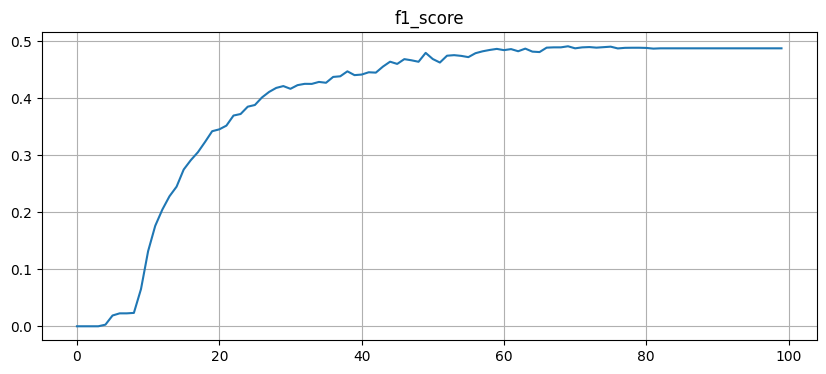

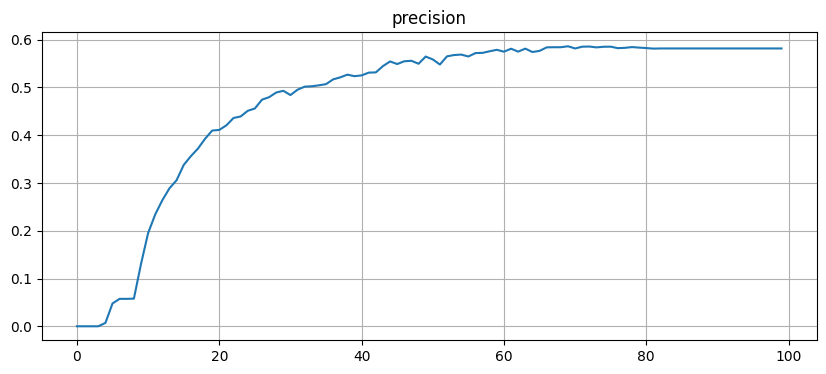

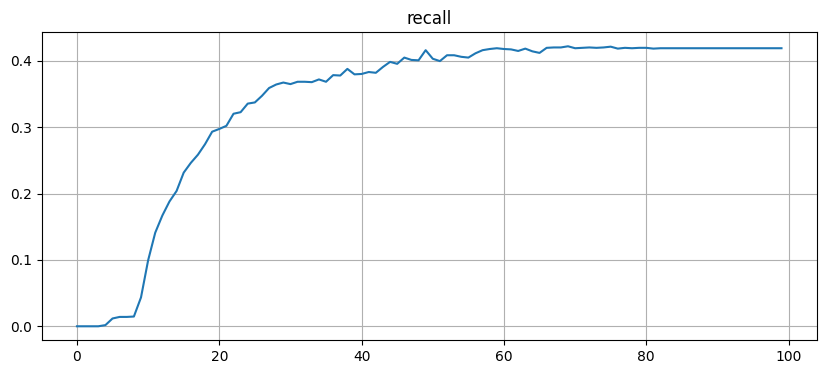

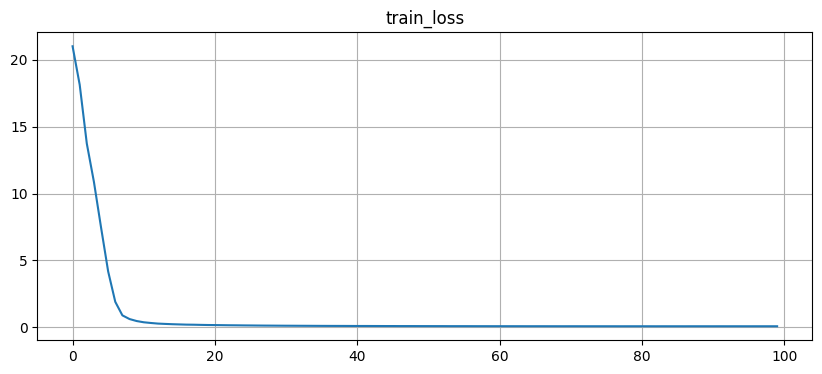

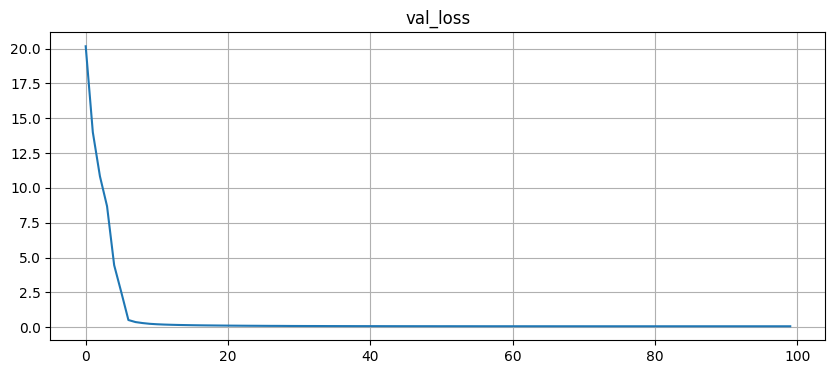

In [27]:
'''plt.figure (figsize = (10, 4))
for i, (name, history) in enumerate (sorted (metrics.items ())):
    plt.subplot (1, len (metrics), i + 1)
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
plt.show ()'''

for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()


In [28]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model (input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        outputs = outputs.logits.argmax(-1)

        #print (outputs)
        print (tokenizer.batch_decode (labels))
        print (tokenizer.batch_decode (outputs))

        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        print (sanity_check (outputs, labels, to_print = True))

        break

['семантики <extra_id_0> термина <extra_id_0> терминоведения <extra_id_0> переводоведения <extra_id_0> лексикографии</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'глобальную оптимизацию <extra_id_0> оптимизацию <extra_id_0> генетического алгоритма <extra_id_0> алгоритма <extra_id_0> эвристик <extra_id_0> размерность задачи</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [29]:
model

MT5ForConditionalGeneration(
  (shared): Embedding(20100, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(20100, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
            

In [30]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test: ', sanity_check (val_preds, val_labels))

100%|██████████| 53/53 [00:10<00:00,  4.99it/s]


Validation:  (0.5815660685154975, 0.4191651969429747, 0.4871882473522378)


100%|██████████| 53/53 [00:10<00:00,  5.10it/s]


Test:  (0.584934665641814, 0.47296457426973276, 0.5230240549828178)


In [31]:

NUM_BEAMS = 1

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation wmax: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test wmax: ', sanity_check (val_preds, val_labels))

100%|██████████| 53/53 [00:31<00:00,  1.70it/s]


Validation wmax:  (0.6291946308724832, 0.6613756613756614, 0.644883920894239)


100%|██████████| 53/53 [00:29<00:00,  1.79it/s]


Test wmax:  (0.6287015945330297, 0.6861404599129894, 0.6561664190193165)


In [32]:
val_preds [0]

tensor([    0,  7389,  6587,   544, 19868,   657, 10332,   308, 20099,   544,
        19868,   657, 10332,   308, 20099, 10332,   411,  6335, 20099,  8419,
          411,  6335, 20099, 17374,  1040, 17519,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0], device='cuda:0')

In [33]:
#model.save_pretrained('./coint_rut5small_finetune_5875')
#tokenizer.save_pretrained('./coint_rut5small_finetune_5875')